#### rho_d in this code is zeta_d of the paper

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import os
import sys
import time
from numba.experimental import jitclass
from numba import double, float32, int32, boolean, typeof
from numba import jit
from numba.types import Tuple, List

from mpl_toolkits.axes_grid1 import make_axes_locatable
from pimg import PBayer
import glob
import json

print(cv2.__version__)
print(np.__version__)
pi = np.pi


4.4.0
1.19.1


#### get AoLP and DoLP from captured image

In [2]:
###############################################################
w = 1224
h = 1024
IMAGE_PATH = '../../../data/sky/out/HDR/black_tourtle/'
CALIB_PATH = '../../../data/sky/calib/'


In [3]:
mask_full = cv2.imread(IMAGE_PATH +'mask_skyarea.png',  cv2.IMREAD_GRAYSCALE).astype(np.float32) /(255-1.0)
mask = mask_full[::2,::2]
# mask_sky_full = cv2.imread(IMAGE_PATH +'mask_sky.png',  cv2.IMREAD_GRAYSCALE).astype(np.float32) /(255-1.0)
# mask_sky = mask_sky_full[::2,::2]

h, w = mask.shape
print(h,w)

# quiver
skipStep=50
pixelPositions_all = np.mgrid[0:w, 0:h].T # h, w, 2
pixelPositions = pixelPositions_all[::skipStep, ::skipStep,:].reshape(-1,2)
pixelU = pixelPositions[:,0] 
pixelV = pixelPositions[:,1]

1024 1224


### function to calculate residual

In [4]:
import mueller
import stokes
# variables : I_d, t_d, I_s, rho_d, scalar coefficients, azimuth angle and zenith angle 
# azimuth limitation : [-pi , 0] yz-plane
# zenith limitation : [0 , pi] x-axis
@jit
def getResidual_init( variables, observed_stokes ,refractive_index, sun_dir, DoLPsmax, skyModelParams,zenith):
    image_num = observed_stokes.shape[0]
    pixel_num = observed_stokes.shape[1]
    
    I_d = np.ones(image_num)
    I_d[1:image_num] = variables[0:image_num-1]
    t_d = variables[image_num-1]
    I_s = I_d*t_d
    rho_d = variables[image_num]
    I_zeta = variables[image_num+1:2*image_num+1]
    
    residual = np.zeros(4*image_num*pixel_num)
    for i in range(0,pixel_num):
        offset = 2*image_num+1+2*i
        n = np.zeros((3))
        n[0] = np.cos(variables[offset+1])
        n[1] = np.cos(variables[offset])*np.sin(variables[offset+1])
        n[2] = np.sin(variables[offset])*np.sin(variables[offset+1])
        
        residual[4*image_num*i:4*image_num*(i+1)] = stokes.getOnePixelResidual_PerezSkyModel_Timevariation(n, observed_stokes[:,i], refractive_index, sun_dir, DoLPsmax, I_zeta, I_d, I_s, rho_d, skyModelParams, zenith)
    return residual


In [5]:
import stokes
# variables : I_d, t_d, I_s, rho_d, scalar coefficients
@jit
def getResidual( variables, observed_stokes, n, refractive_index, sun_dir, DoLPsmax, skyModelParams,zenith):
    image_num = observed_stokes.shape[0]
    pixel_num = observed_stokes.shape[1]
    
    I_d = np.ones(image_num)
    I_d[1:image_num] = variables[0:image_num-1]
    t_d = variables[image_num-1]
    I_s = I_d*t_d
    rho_d = variables[image_num]
    I_zeta = variables[image_num+1:2*image_num+1]
    
    residual = np.zeros(4*image_num*pixel_num)
    for i in range(0,pixel_num):
        n_i = n[i]        
        residual[4*image_num*i:4*image_num*(i+1)] = stokes.getOnePixelResidual_PerezSkyModel_Timevariation(n_i, observed_stokes[:,i], refractive_index, sun_dir, DoLPsmax, I_zeta, I_d, I_s, rho_d, skyModelParams, zenith)
    return residual


In [6]:
import stokes
# variables : azimuth angle, zenith angle
# azimuth limitation : [-pi , 0] yz-plane
# zenith limitation : [0 , pi] x-axis
@jit
def getResidual2( variables, observed_stokes ,refractive_index, sun_dir, DoLPsmax, I_zeta, I_d, I_s, rho_d, skyModelParams, zenith,mask):
    image_num = observed_stokes.shape[0]
    pixely_num = observed_stokes.shape[1] 
    pixelx_num = observed_stokes.shape[2]
    pixel_num = pixelx_num*pixely_num
    
    n = np.zeros((3))
    n[0] = np.cos(variables[1])
    n[1] = np.cos(variables[0])*np.sin(variables[1])
    n[2] = np.sin(variables[0])*np.sin(variables[1])
    
    residual = np.zeros(4*image_num*pixel_num)
    for i in range(0, pixely_num):
        for j in range(0, pixelx_num):
            iteration = i*pixelx_num + j
            if mask[i,j] >=1:
                residual[4*image_num*iteration : 4*image_num*(iteration+1)] = stokes.getOnePixelResidual_PerezSkyModel_Timevariation(n, observed_stokes[:,i,j], refractive_index, sun_dir, DoLPsmax, I_zeta, I_d, I_s, rho_d, skyModelParams, zenith)
            else:
                residual[4*image_num*iteration : 4*image_num*(iteration+1)] = 0
    return residual


In [7]:
import normal
def estimateNormal(step, pixel_range, n_init, bounds, observed_stokes, refractive_index, sun_dir, DoLPsmax, I_zeta, I_d, I_s, rho_d, skyModelParams, zenith, mask):
    phi_est, theta_est = normal.n2pt_x(n_init)
    h = n_init.shape[0]
    w = n_init.shape[1]
    for i in range(0, h, step):
        if (i/step)%10==0:
            print('i: '+str(i)) 

        for j in range(0, w,step):
            if mask[i,j] >= 1:
                # take neighbor pixel
                up = i-pixel_range
                down = i+pixel_range+1
                left = j-pixel_range
                right = j+pixel_range+1
                if (up<0) | (down>=h) | (left<0) | (right>=w):
                    continue
                observed_stokes_ = observed_stokes[:, up:down, left:right]
                mask_ = mask[up:down, left:right]

                x0 = np.array([phi_est[i,j], theta_est[i,j]])
                ret = least_squares(getResidual2,x0=x0, bounds=bounds, 
                                    args=(observed_stokes_, refractive_index, sun_dir, DoLPsmax, I_zeta_est, I_d_est, I_s_est, rho_d_est, skyModelParams, zenith, mask_))

                #take pixel to update
                width = step//2
                up = np.max([i-width, 0])
                down = np.min([i+width+1, h])
                left = np.max([j-width, 0])
                right = np.min([j+width+1, w])
                phi_est[up:down, left:right] = ret.x[0]
                theta_est[up:down, left:right] = ret.x[1]
            else:
                phi_est[i,j] = np.nan
                theta_est[i,j] = np.nan

    n_est = normal.pt2n_x(phi_est, theta_est)
    return n_est

## set parameters

In [8]:
# known parameters
refractive_index = 1.80
scene_list = ['1050','1200','1320','1440','1540']
sun_dir_list = np.load('sundir_data/black_tourtle_sundir.npy')
DoLPsmax_list = np.array([0.4,0.4,0.4,0.4,0.4,0.5])
skyModelParams = np.array([-1.0, -0.32, 10, -3.0, 0.45])
z_theta = np.pi/6
zenith = np.array([ 0, -np.cos(z_theta), -np.sin(z_theta)]) # zenith for camera coordinate system
print(sun_dir_list)
print(zenith)

# data index to use for estimation
index_list = np.array([0,3])
# interval of pixel sampling
pixelx_interval_1 =  40
pixely_interval_1 =  40
# step of normal estimation
step1 = 8
# range of neighbor pixel e.g. range=1 is 3x3 pixels
pixel_range1 = 2

# interval of pixel sampling
pixelx_interval_2 =  1
pixely_interval_2 =  1
# step of normal estimation
step2 = np.array([1])
step = step2[-1]
# range of neighbor pixel e.g. range=1 is 3x3 pixels
pixel_range2 = np.array([1])
# number of iteration
iteration_num = step2.shape[0]

# initial values
I_d_init = 1
t_d_init = 1
rho_d_init = 1e-9
I_zeta_init = 1
phi_init = -np.pi*5/6 # yz-plane azimuth angle
theta_init = np.pi/2 # x-axis zenith angle

t_d_min = 0
t_d_max = np.inf

[[ 0.16224932  0.02648254 -0.98639436]
 [-0.15066037  0.01035251 -0.98853137]
 [-0.46080595  0.00458513 -0.88748907]
 [-0.72654443  0.04305343 -0.68576934]
 [-0.88612334  0.09845134 -0.45287168]]
[ 0.        -0.8660254 -0.5      ]


## estimate initial normal

pixel_num : 79
I_d: [1.         0.67474118]
t_d: 0.43758346020758593
rho_d: 0.04200242531823134
I_zeta: [0.53638251 0.52258946]
error: 0.004604451611156782
i: 0
i: 80
i: 160
i: 240
i: 320
i: 400
i: 480
i: 560
i: 640
i: 720
i: 800
i: 880
i: 960


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


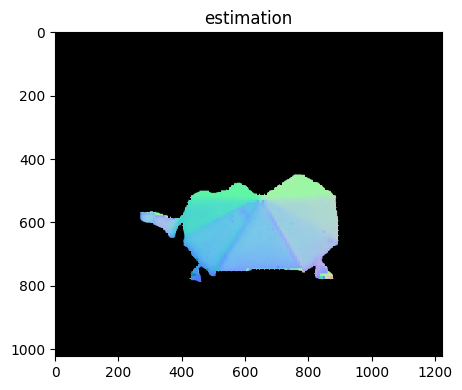

In [9]:
from scipy.optimize import least_squares

image_num = index_list.shape[0]
observed_stokes = np.zeros((image_num,h,w,4))
sun_dir = np.zeros((image_num, 3))
DoLPsmax = np.zeros((image_num))


I_d_est = np.zeros((image_num))
t_d_est = 0
rho_d_est = 0
I_zeta_est = 0
n_est = np.zeros((h,w,3))

for i in range(image_num):
    index = index_list[i]
    
    pimg = cv2.imread(IMAGE_PATH + scene_list[index] +'/L.png', cv2.IMREAD_ANYDEPTH | cv2.IMREAD_GRAYSCALE).astype(np.float32) /(256*256-1.0)
    pbayer_ = PBayer(pimg)
    observed_stokes[i] = pbayer_.stokes

    sun_dir[i] = sun_dir_list[index]
    
    DoLPsmax[i] = DoLPsmax_list[index]

#sampling some pixels to estimate uniform parameters
pixel_num = 0
max_pixel_num = int(np.ceil((h/pixely_interval_1+1)*(w/pixelx_interval_1+1)))
sampled_observed_stokes = np.zeros((image_num, max_pixel_num, 4))
for i in range(0,h,pixely_interval_1):
    for j in range(0,w,pixelx_interval_1):
        if mask[i,j] >= 1:
            sampled_observed_stokes[:,pixel_num,:] = observed_stokes[:,i,j,:]
            pixel_num += 1
sampled_observed_stokes = sampled_observed_stokes[:,0:pixel_num,:]
print("pixel_num : "+str(pixel_num))

sep1 = image_num-1 # I_d
sep2 = image_num # t_d
sep3 = image_num+1 # rho_d
sep4 = 2*image_num+1 # I_zata
sep5 = 2*image_num+1+2*pixel_num # normals
# initial value
x0 = np.zeros((sep5))
x0[0:sep1] = I_d_init
x0[sep1:sep2] = t_d_init
x0[sep2:sep3] = rho_d_init
x0[sep3:sep4] = I_zeta_init
x0[sep4:sep5:2] = phi_init
x0[sep4+1:sep5:2] = theta_init

# boundary
lb = np.zeros((sep5))
lb[0:sep1] = 0
lb[sep1:sep2] = t_d_min
lb[sep2:sep3] =0
lb[sep3:sep4] = 0
lb[sep4:sep5:2] = -np.pi
lb[sep4+1:sep5:2] = 0

ub = np.zeros((sep5))
ub[0:sep1] = np.inf
ub[sep1:sep2] = np.inf
ub[sep2:sep3] = np.inf
ub[sep3:sep4] = np.inf
ub[sep4:sep5:2] = 0
ub[sep4+1:sep5:2] = np.pi
lb_list = lb.tolist()
ub_list = ub.tolist()

ret = least_squares(getResidual_init,x0=x0, bounds=(lb_list,ub_list), 
                    args=(sampled_observed_stokes, refractive_index, sun_dir, DoLPsmax, skyModelParams, zenith), max_nfev=100)
I_d_est[0] = 1
I_d_est[1:image_num] = ret.x[0:sep1]
t_d_est = ret.x[sep1]
rho_d_est = ret.x[sep2]
I_zeta_est = ret.x[sep3:sep4]
print('I_d: '+str(I_d_est))
print('t_d: '+str(t_d_est))
print('rho_d: '+str(rho_d_est))
print('I_zeta: '+str(I_zeta_est))
print('error: '+str(ret.cost))
I_s_est = I_d_est*t_d_est


# estimate normal

# initial value
n_init = np.zeros((h,w,3))
n_init[:,:] = normal.pt2n_x_scalar(phi_init,theta_init)
# boundary
lb = np.zeros((2))
lb[0] = -np.pi
lb[1] = 0
ub = np.zeros((2))
ub[0] = 0
ub[1] = np.pi
lb_list = lb.tolist()
ub_list = ub.tolist()
bounds = (lb_list,ub_list)

n_est = estimateNormal(step1, pixel_range1, n_init, bounds, observed_stokes, refractive_index, sun_dir, DoLPsmax, I_zeta_est, I_d_est, I_s_est, rho_d_est, skyModelParams, zenith, mask)
            
plt.figure(figsize=(5,5), dpi=100)
plt.imshow(mueller.getNormalImg(n_est[::step,::step]) * mask[::step,::step,np.newaxis]),plt.title('estimation')
plt.show()   

## alternating minimization

iteration: 0
pixel_num : 130265
I_d: [1.         0.63259594]
t_d: 0.15114189934875844
rho_d: 0.04906512632053562
I_zeta: [0.56657033 0.55646859]
error: 98.83896524188226
i: 0
i: 10
i: 20
i: 30
i: 40
i: 50
i: 60
i: 70
i: 80
i: 90
i: 100
i: 110
i: 120
i: 130
i: 140
i: 150
i: 160
i: 170
i: 180
i: 190
i: 200
i: 210
i: 220
i: 230
i: 240
i: 250
i: 260
i: 270
i: 280
i: 290
i: 300
i: 310
i: 320
i: 330
i: 340
i: 350
i: 360
i: 370
i: 380
i: 390
i: 400
i: 410
i: 420
i: 430
i: 440
i: 450
i: 460
i: 470
i: 480
i: 490
i: 500
i: 510
i: 520
i: 530
i: 540
i: 550
i: 560
i: 570
i: 580
i: 590
i: 600
i: 610
i: 620
i: 630
i: 640
i: 650
i: 660
i: 670
i: 680
i: 690
i: 700
i: 710
i: 720
i: 730
i: 740
i: 750
i: 760
i: 770
i: 780
i: 790
i: 800
i: 810
i: 820
i: 830
i: 840
i: 850
i: 860
i: 870
i: 880
i: 890
i: 900
i: 910
i: 920
i: 930
i: 940
i: 950
i: 960
i: 970
i: 980
i: 990
i: 1000
i: 1010
i: 1020


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


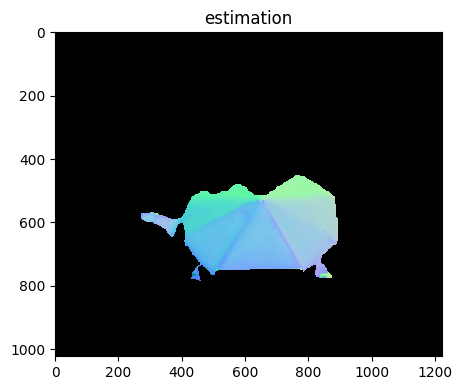

In [10]:
sep1 = image_num-1 # I_d
sep2 = image_num # t_d
sep3 = image_num+1 # rho_d
sep4 = 2*image_num+1 # I_zata
# first step boundary
lb_1 = np.zeros((sep4))
lb_1[0:sep1] = 0
lb_1[sep1:sep2] = t_d_min
lb_1[sep2:sep3] =0
lb_1[sep3:sep4] = 0
ub_1 = np.zeros((sep4))
ub_1[0:sep1] = np.inf
ub_1[sep1:sep2] = np.inf
ub_1[sep2:sep3] = np.inf
ub_1[sep3:sep4] = np.inf
lb_list_1 = lb_1.tolist()
ub_list_1 = ub_1.tolist()

# second step boundary
lb_2 = np.zeros((2))
lb_2[0] = -np.pi # phi
lb_2[1] = 0 # theta
ub_2 = np.zeros((2))
ub_2[0] = 0
ub_2[1] = np.pi
lb_list_2 = lb_2.tolist()
ub_list_2 = ub_2.tolist()
bounds2 = (lb_list_2, ub_list_2)

error = np.zeros((h,w))
for ite in range(0,iteration_num):
    print('iteration: '+str(ite))
    
    # initial value
    x0_1 = np.zeros((sep4))
    x0_1[0:sep1] = I_d_est[1:]
    x0_1[sep1:sep2] = t_d_est
    x0_1[sep2:sep3] = rho_d_est
    x0_1[sep3:sep4] = I_zeta_est    
    
    #sampling some pixels to estimate uniform parameters
    pixel_num = 0
    max_pixel_num = int(np.ceil((h/pixely_interval_2+1)*(w/pixelx_interval_2+1)))
    sampled_observed_stokes = np.zeros((image_num, max_pixel_num, 4))
    sampled_n_est = np.zeros((max_pixel_num, 3))
    for i in range(0,h,pixely_interval_2):
        for j in range(0,w,pixelx_interval_2):
            if mask[i,j] >= 1:
                sampled_observed_stokes[:,pixel_num,:] = observed_stokes[:,i,j,:]
                sampled_n_est[pixel_num] = n_est[i,j]
                pixel_num += 1
    sampled_observed_stokes = sampled_observed_stokes[:,0:pixel_num,:]
    sampled_n_est = sampled_n_est[0:pixel_num]
    print("pixel_num : "+str(pixel_num))
    
    ret = least_squares(getResidual,x0=x0_1, bounds=(lb_list_1,ub_list_1), 
                        args=(sampled_observed_stokes, sampled_n_est, refractive_index, sun_dir, DoLPsmax, skyModelParams, zenith), max_nfev=100)
    
    I_d_est[0] = 1
    I_d_est[1:image_num] = ret.x[0:sep1]
    t_d_est = ret.x[sep1]
    rho_d_est = ret.x[sep2]
    I_zeta_est = ret.x[sep3:sep4]
    print('I_d: '+str(I_d_est))
    print('t_d: '+str(t_d_est))
    print('rho_d: '+str(rho_d_est))
    print('I_zeta: '+str(I_zeta_est))
    print('error: '+str(ret.cost))
    I_s_est = I_d_est*t_d_est
    
    # estimate normal
    n_est = estimateNormal(step2[ite], pixel_range2[ite], n_est, bounds2, observed_stokes, refractive_index, sun_dir, DoLPsmax, I_zeta_est, I_d_est, I_s_est, rho_d_est, skyModelParams, zenith, mask)
    
    plt.figure(figsize=(5,5), dpi=100)
    plt.imshow(mueller.getNormalImg(n_est[::step,::step]) * mask[::step,::step,np.newaxis]),plt.title('estimation')
    plt.show()

In [11]:
print('I_d: '+str(I_d_est))
print('t_d: '+str(t_d_est))
print('rho_d: '+str(rho_d_est))
print('I_zeta: '+str(I_zeta_est))

I_d: [1.         0.63259594]
t_d: 0.15114189934875844
rho_d: 0.04906512632053562
I_zeta: [0.56657033 0.55646859]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


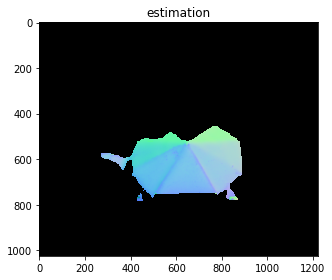

In [12]:
plt.figure(figsize=(5,5))
plt.imshow(mueller.getNormalImg(n_est[::step,::step]) * mask[::step,::step,np.newaxis]),plt.title('estimation')
plt.show()

In [13]:
# save

save_file = 'normal_data/black_tourtle_1050_1440'
np.save(save_file, n_est)
